In [1]:
import numpy as np
import scipy.optimize as scop
import astropy.units as u
import astropy.constants as consts
import matplotlib.pyplot as plt

# First deal with LYSO and then GaGG

## Extract LYSO scintillation spectrum
## data from [10.3390/ma4071224](http://dx.doi.org/10.3390/ma4071224)

In [2]:
# retroactively import a Geant SiPM energy output for comparison
# records energies in eV
fn = 'geant4-example-sipm-out.tab'
g4_energies = np.loadtxt(fn)[1:]

In [3]:
s = '''3.44e+2 0
3.61e+2 3.21e-3
3.72e+2 3.82e-2
3.78e+2 9.60e-2
3.81e+2 1.54e-1
3.83e+2 2.09e-1
3.87e+2 3.18e-1
3.85e+2 2.53e-1
3.89e+2 3.94e-1
3.90e+2 4.46e-1
3.93e+2 5.10e-1
3.94e+2 5.72e-1
3.96e+2 6.33e-1
3.99e+2 7.04e-1
4.02e+2 7.62e-1
4.05e+2 8.22e-1
4.09e+2 8.89e-1
4.15e+2 9.41e-1
4.26e+2 9.85e-1
4.37e+2 9.51e-1
4.41e+2 8.99e-1
4.45e+2 8.40e-1
4.48e+2 7.85e-1
4.51e+2 7.29e-1
4.54e+2 6.75e-1
4.57e+2 6.06e-1
4.60e+2 5.52e-1
4.63e+2 4.97e-1
4.67e+2 4.31e-1
4.71e+2 3.65e-1
4.76e+2 3.07e-1
4.81e+2 2.50e-1
4.88e+2 1.92e-1
4.96e+2 1.39e-1
5.09e+2 8.31e-2
5.26e+2 4.57e-2
5.42e+2 2.99e-2
5.59e+2 1.81e-2
5.76e+2 1.25e-2
5.92e+2 8.55e-3
6.09e+2 4.71e-3
6.26e+2 3.00e-3
6.42e+2 8.66e-4
6.59e+2 0
6.71e+2 0'''

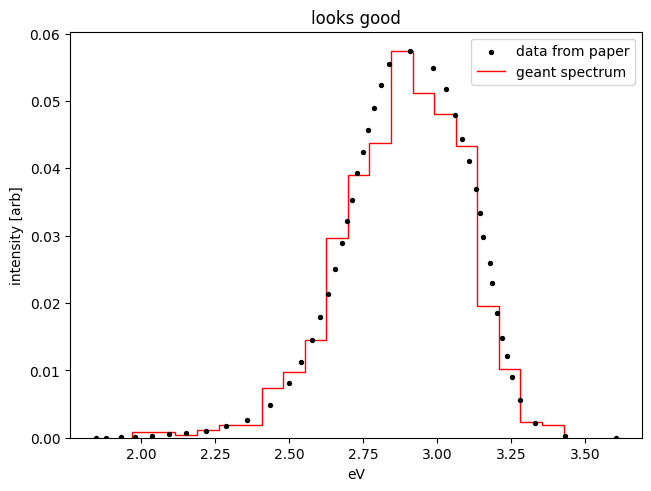

In [4]:
splitted = s.split('\n')
wav, intens = [], []
for sp in splitted:
    w, i = sp.split()
    wav.append(float(w))
    intens.append(float(i))

wav = np.array(wav) << u.nm
e = (consts.c * consts.h / wav).to(u.eV)

intens = np.array(intens) << u.one
argsrt = np.argsort(e)
e = e[argsrt]
intens = intens[argsrt]
intens[intens < 0] = 0
intens /= intens.sum()

fig, ax = plt.subplots(layout='constrained')

ax.scatter(e, intens, color='black', s=8, label='data from paper')

hg, bins = np.histogram(g4_energies, bins=20)
hg = intens.max() * hg / hg.max()
ax.stairs(hg, bins, color='red', zorder=-1, label='geant spectrum')

ax.set(title='looks good', xlabel=e.unit, ylabel='intensity [arb]')
ax.legend()
None

### format for C++ header

In [5]:
for i, ee in enumerate(e):
    print(f'{ee.value:.2f}*eV', end=', ')
    if (i + 1) % 8 == 0: print()
print()
print()
for idx, i in enumerate(intens):
    print(f'{i.value:.2e}', end=', ')
    if (idx + 1) % 8 == 0: print()

1.85*eV, 1.88*eV, 1.93*eV, 1.98*eV, 2.04*eV, 2.09*eV, 2.15*eV, 2.22*eV, 
2.29*eV, 2.36*eV, 2.44*eV, 2.50*eV, 2.54*eV, 2.58*eV, 2.60*eV, 2.63*eV, 
2.65*eV, 2.68*eV, 2.70*eV, 2.71*eV, 2.73*eV, 2.75*eV, 2.77*eV, 2.79*eV, 
2.81*eV, 2.84*eV, 2.91*eV, 2.99*eV, 3.03*eV, 3.06*eV, 3.08*eV, 3.11*eV, 
3.13*eV, 3.15*eV, 3.15*eV, 3.18*eV, 3.19*eV, 3.20*eV, 3.22*eV, 3.24*eV, 
3.25*eV, 3.28*eV, 3.33*eV, 3.43*eV, 3.60*eV, 

0.00e+00, 0.00e+00, 5.05e-05, 1.75e-04, 2.75e-04, 4.98e-04, 7.29e-04, 1.06e-03, 
1.74e-03, 2.66e-03, 4.84e-03, 8.10e-03, 1.12e-02, 1.46e-02, 1.79e-02, 2.13e-02, 
2.51e-02, 2.90e-02, 3.22e-02, 3.53e-02, 3.93e-02, 4.25e-02, 4.58e-02, 4.90e-02, 
5.24e-02, 5.54e-02, 5.74e-02, 5.49e-02, 5.18e-02, 4.79e-02, 4.44e-02, 4.10e-02, 
3.69e-02, 3.33e-02, 2.97e-02, 2.60e-02, 2.30e-02, 1.85e-02, 1.47e-02, 1.22e-02, 
8.98e-03, 5.60e-03, 2.23e-03, 1.87e-04, 0.00e+00, 

# Fit the refractive index of LYSO across relevant energies

## LYSO data from [10.1109/TNS.2008.2000776](https://doi.org/10.1109/TNS.2008.2000776)

In [6]:
# measured refractive indices
n = np.array([1.806, 1.810, 1.813, 1.822, 1.827, 1.833])
# energies from wavelengths of light
e = (consts.c * consts.h / (np.array([546, 516, 486, 436, 420, 405]) << u.nm)).to(u.eV)

### Fit the [Sellmeier equation](https://en.wikipedia.org/wiki/Sellmeier_equation) to the data

In [7]:
def sellmeier(e, a, b, c, d, f):
    terms = []
    x = (consts.h * consts.c / (e << u.eV)).to(u.nm).value
    terms.append(1)
    terms.append(a * x**2 / (x**2 - b))
    terms.append(c * x**2 / (x**2 - d))
    return f + sum(terms)

p, _ = scop.curve_fit(sellmeier, e.value, n**2, maxfev=200000)
p

array([ 7.36661517e+01,  3.23426102e+02,  6.36315874e-03,  1.40074000e+05,
       -7.14952402e+01])

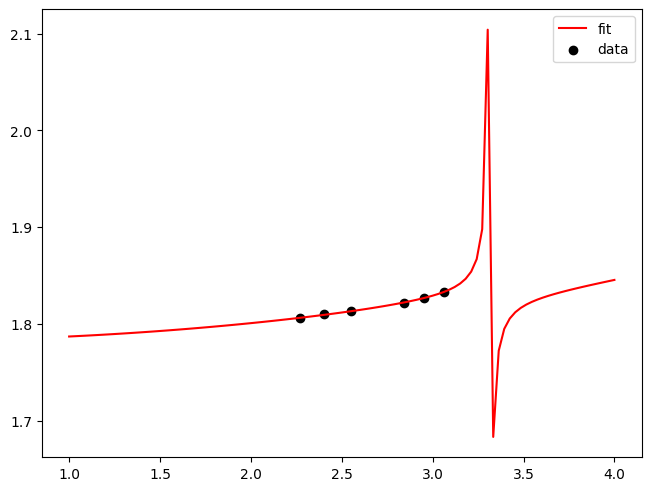

In [8]:
fig, ax = plt.subplots(layout='constrained')
energiez = np.linspace(1, 4, num=100)
ax.plot(energiez, np.sqrt(sellmeier(energiez, *p)), color='red', label='fit')
ax.scatter(e.value, n, color='black', label='data')
ax.legend()
plt.show()

### The Sellmeier equation breaks down at short wavelengths, so cap it at the max value for energies > ~3 eV

In [9]:
sample = np.arange(1, 4.5, 0.5) << u.eV
n_sample = np.sqrt(sellmeier(sample.value, *p))
n_sample[sample > (3 << u.eV)] = 2.1

In [10]:
print(', '.join(f'{s:.2f}' for s in n_sample))
print(', '.join(f'{s.value:.2f}*eV' for s in sample))

1.79, 1.79, 1.80, 1.81, 1.83, 2.10, 2.10
1.00*eV, 1.50*eV, 2.00*eV, 2.50*eV, 3.00*eV, 3.50*eV, 4.00*eV


## Same as above but for GaGG

### optical spectrum from [here](https://www.scintillator-crylink.com/product/cegagg/)

In [17]:
gagg_str = '''4.520e+2 1.258e-2
4.605e+2 2.360e-2
4.685e+2 4.638e-2
4.739e+2 1.101e-1
4.769e+2 1.811e-1
4.800e+2 2.479e-1
4.830e+2 3.182e-1
4.850e+2 3.961e-1
4.873e+2 4.694e-1
4.895e+2 5.613e-1
4.903e+2 6.568e-1
4.918e+2 7.276e-1
4.941e+2 8.057e-1
4.957e+2 8.820e-1
4.964e+2 9.720e-1
4.980e+2 1.047e+0
5.005e+2 1.129e+0
5.026e+2 1.218e+0
5.049e+2 1.302e+0
5.075e+2 1.381e+0
5.106e+2 1.453e+0
5.137e+2 1.524e+0
5.171e+2 1.595e+0
5.232e+2 1.656e+0
5.316e+2 1.677e+0
5.401e+2 1.660e+0
5.481e+2 1.620e+0
5.542e+2 1.552e+0
5.588e+2 1.488e+0
5.645e+2 1.432e+0
5.703e+2 1.370e+0
5.745e+2 1.302e+0
5.783e+2 1.240e+0
5.825e+2 1.182e+0
5.867e+2 1.119e+0
5.906e+2 1.057e+0
5.944e+2 9.895e-1
5.986e+2 9.228e-1
6.032e+2 8.617e-1
6.078e+2 8.020e-1
6.120e+2 7.381e-1
6.158e+2 6.730e-1
6.200e+2 6.086e-1
6.250e+2 5.441e-1
6.307e+2 4.857e-1
6.365e+2 4.267e-1
6.422e+2 3.630e-1
6.495e+2 3.043e-1
6.579e+2 2.582e-1
6.663e+2 2.161e-1
6.748e+2 1.805e-1
6.832e+2 1.497e-1
6.916e+2 1.243e-1
7.000e+2 1.038e-1
7.084e+2 8.651e-2
7.168e+2 7.147e-2
7.253e+2 5.819e-2
7.337e+2 4.816e-2
7.421e+2 4.140e-2
7.505e+2 3.939e-2
7.589e+2 3.488e-2
7.674e+2 2.987e-2
7.758e+2 2.435e-2
7.838e+2 1.358e-2'''
both = gagg_str.split('\n')
wav, unsorted_intens = [], []
for pair in both:
    w, i = pair.split()
    wav.append(float(w))
    unsorted_intens.append(float(i))

In [25]:
# retroactively import a Geant SiPM energy output for comparison
# records energies in eV
fn = 'sipm-energies-out-gagg.tab'
g4_energies = np.loadtxt(fn)[1:]

hg, bins = np.histogram(g4_energies, bins=30)

In [26]:
energy = (consts.c * consts.h / (np.array(wav) << u.nm)).to(u.eV)
intensity = np.array(unsorted_intens)

srt = np.argsort(energy)
energy = energy[srt]
intensity = intensity[srt]

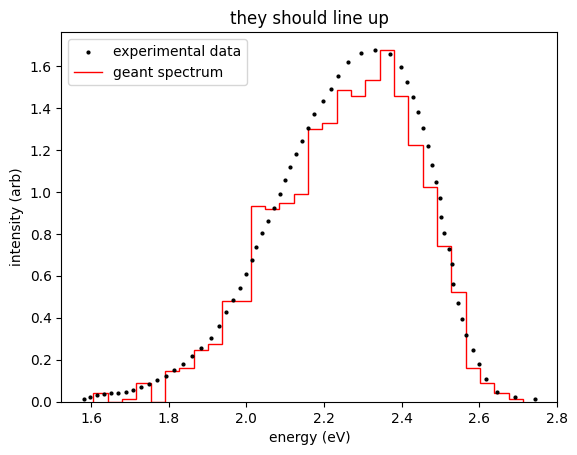

In [27]:
fig, ax = plt.subplots()
ax.scatter(energy, intensity, color='black', label='experimental data', s=4)
ax.stairs(intensity.max() * hg / hg.max(), bins, color='red', zorder=-1, label='geant spectrum')
ax.set(title='they should line up', xlabel='energy (eV)', ylabel='intensity (arb)')
ax.legend()
None

In [58]:
for e in energy:
    print(f'{e.value:.2f}', end=', ')

1.58, 1.60, 1.62, 1.63, 1.65, 1.67, 1.69, 1.71, 1.73, 1.75, 1.77, 1.79, 1.81, 1.84, 1.86, 1.88, 1.91, 1.93, 1.95, 1.97, 1.98, 2.00, 2.01, 2.03, 2.04, 2.06, 2.07, 2.09, 2.10, 2.11, 2.13, 2.14, 2.16, 2.17, 2.20, 2.22, 2.24, 2.26, 2.30, 2.33, 2.37, 2.40, 2.41, 2.43, 2.44, 2.46, 2.47, 2.48, 2.49, 2.50, 2.50, 2.51, 2.52, 2.53, 2.53, 2.54, 2.56, 2.57, 2.58, 2.60, 2.62, 2.65, 2.69, 2.74, 

In [59]:
intensity = intensity / intensity.sum()
for i in intensity:
    print(f'{i:.3e}', end=', ')

3.044e-04, 5.458e-04, 6.695e-04, 7.818e-04, 8.829e-04, 9.279e-04, 1.079e-03, 1.304e-03, 1.602e-03, 1.939e-03, 2.327e-03, 2.786e-03, 3.355e-03, 4.046e-03, 4.844e-03, 5.787e-03, 6.821e-03, 8.136e-03, 9.564e-03, 1.089e-02, 1.220e-02, 1.364e-02, 1.508e-02, 1.654e-02, 1.798e-02, 1.931e-02, 2.068e-02, 2.218e-02, 2.369e-02, 2.508e-02, 2.649e-02, 2.779e-02, 2.918e-02, 3.071e-02, 3.210e-02, 3.335e-02, 3.479e-02, 3.631e-02, 3.721e-02, 3.759e-02, 3.712e-02, 3.575e-02, 3.416e-02, 3.257e-02, 3.095e-02, 2.918e-02, 2.730e-02, 2.531e-02, 2.347e-02, 2.179e-02, 1.977e-02, 1.806e-02, 1.631e-02, 1.472e-02, 1.258e-02, 1.052e-02, 8.878e-03, 7.132e-03, 5.556e-03, 4.059e-03, 2.468e-03, 1.040e-03, 5.290e-04, 2.820e-04, 

### Index of refraction from [10.1016/j.jcrysgro.2016.04.037](10.1016/j.jcrysgro.2016.04.037)

In [79]:
gagg_refr_str = '''2.455e+2 1.971e+0
2.443e+2 1.970e+0
2.453e+2 1.967e+0
2.480e+2 1.965e+0
2.494e+2 1.963e+0
2.501e+2 1.961e+0
2.503e+2 1.959e+0
2.525e+2 1.958e+0
2.546e+2 1.952e+0
2.540e+2 1.956e+0
2.538e+2 1.954e+0
2.582e+2 1.949e+0
2.588e+2 1.947e+0
2.606e+2 1.944e+0
2.623e+2 1.942e+0
2.638e+2 1.941e+0
2.657e+2 1.939e+0
2.669e+2 1.937e+0
2.682e+2 1.935e+0
2.703e+2 1.934e+0
2.717e+2 1.931e+0
2.742e+2 1.930e+0
2.742e+2 1.928e+0
2.764e+2 1.926e+0
2.795e+2 1.924e+0
2.825e+2 1.922e+0
2.843e+2 1.921e+0
2.878e+2 1.919e+0
2.909e+2 1.917e+0
2.938e+2 1.916e+0
2.952e+2 1.914e+0
2.975e+2 1.911e+0
2.995e+2 1.910e+0
3.033e+2 1.908e+0
3.066e+2 1.906e+0
3.102e+2 1.904e+0
3.119e+2 1.903e+0
3.166e+2 1.901e+0
3.178e+2 1.899e+0
3.164e+2 1.898e+0
3.213e+2 1.902e+0
3.235e+2 1.900e+0
3.252e+2 1.898e+0
3.300e+2 1.896e+0
3.318e+2 1.894e+0
3.370e+2 1.893e+0
3.414e+2 1.894e+0
3.465e+2 1.892e+0
3.501e+2 1.890e+0
3.531e+2 1.888e+0
3.517e+2 1.893e+0
3.510e+2 1.892e+0
3.535e+2 1.886e+0
3.537e+2 1.890e+0
3.595e+2 1.887e+0
3.658e+2 1.886e+0
3.707e+2 1.887e+0
3.747e+2 1.885e+0
3.749e+2 1.884e+0
3.816e+2 1.884e+0
3.877e+2 1.883e+0
3.905e+2 1.881e+0
3.977e+2 1.881e+0
4.014e+2 1.880e+0
4.013e+2 1.882e+0
4.057e+2 1.878e+0
4.096e+2 1.880e+0
4.105e+2 1.881e+0
4.160e+2 1.878e+0
4.217e+2 1.877e+0
4.237e+2 1.876e+0
4.306e+2 1.877e+0
4.387e+2 1.877e+0
4.445e+2 1.876e+0
4.502e+2 1.875e+0
4.575e+2 1.876e+0
4.652e+2 1.875e+0
4.726e+2 1.875e+0
4.761e+2 1.874e+0
4.806e+2 1.874e+0
4.876e+2 1.875e+0
4.951e+2 1.874e+0
5.003e+2 1.873e+0
5.052e+2 1.874e+0
5.121e+2 1.874e+0
5.195e+2 1.873e+0
5.255e+2 1.873e+0
5.331e+2 1.873e+0
5.406e+2 1.873e+0
5.481e+2 1.873e+0
5.556e+2 1.873e+0
5.630e+2 1.873e+0
5.705e+2 1.873e+0
5.780e+2 1.873e+0
5.855e+2 1.873e+0
5.929e+2 1.873e+0
6.004e+2 1.873e+0
6.079e+2 1.872e+0
6.154e+2 1.873e+0
6.228e+2 1.872e+0
6.303e+2 1.872e+0
6.378e+2 1.872e+0
6.453e+2 1.872e+0
6.527e+2 1.872e+0
6.602e+2 1.872e+0
6.677e+2 1.872e+0
6.752e+2 1.872e+0
6.826e+2 1.873e+0
6.901e+2 1.873e+0
6.976e+2 1.872e+0
7.051e+2 1.872e+0
7.125e+2 1.872e+0
7.200e+2 1.872e+0
7.275e+2 1.873e+0
7.350e+2 1.872e+0
7.430e+2 1.872e+0
7.499e+2 1.872e+0
7.574e+2 1.872e+0
7.649e+2 1.872e+0
7.724e+2 1.872e+0
7.798e+2 1.872e+0
7.873e+2 1.872e+0
7.948e+2 1.873e+0
8.023e+2 1.872e+0
8.097e+2 1.873e+0
8.172e+2 1.872e+0
8.247e+2 1.872e+0
8.326e+2 1.872e+0
8.396e+2 1.872e+0
8.471e+2 1.872e+0
8.546e+2 1.872e+0
8.621e+2 1.872e+0
8.695e+2 1.872e+0
8.772e+2 1.873e+0
8.839e+2 1.873e+0
8.920e+2 1.872e+0
8.994e+2 1.873e+0
9.074e+2 1.873e+0
9.141e+2 1.873e+0
9.219e+2 1.872e+0
9.293e+2 1.873e+0
9.362e+2 1.873e+0
9.443e+2 1.873e+0
9.490e+2 1.874e+0
9.518e+2 1.872e+0
9.592e+2 1.873e+0
9.667e+2 1.872e+0
9.734e+2 1.872e+0
9.780e+2 1.873e+0
9.827e+2 1.873e+0'''
both = gagg_refr_str.split('\n')
wav, unsorted_n = [], []
for pair in both:
    w, ri = pair.split()
    wav.append(float(w))
    unsorted_n.append(float(ri))

In [82]:
energy = consts.c * consts.h / (np.array(wav) << u.nm)
n = np.array(unsorted_n)
srt = np.argsort(energy)
energy = energy[srt].to(u.eV)
n = n[srt]

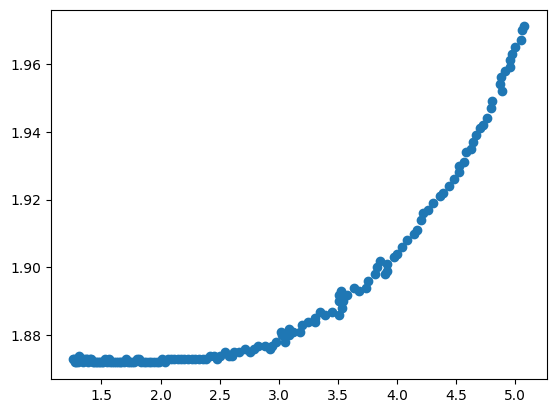

In [83]:
fig, ax = plt.subplots()
ax.scatter(energy, n)

In [84]:
for i, e in enumerate(energy):
    print(f'{e.value:.2f}*eV', end=', ')
    if (i + 1) % 10 == 0: print()

1.26*eV, 1.27*eV, 1.27*eV, 1.28*eV, 1.29*eV, 1.30*eV, 1.31*eV, 1.31*eV, 1.32*eV, 1.33*eV, 
1.34*eV, 1.36*eV, 1.37*eV, 1.38*eV, 1.39*eV, 1.40*eV, 1.41*eV, 1.43*eV, 1.44*eV, 1.45*eV, 
1.46*eV, 1.48*eV, 1.49*eV, 1.50*eV, 1.52*eV, 1.53*eV, 1.55*eV, 1.56*eV, 1.57*eV, 1.59*eV, 
1.61*eV, 1.62*eV, 1.64*eV, 1.65*eV, 1.67*eV, 1.69*eV, 1.70*eV, 1.72*eV, 1.74*eV, 1.76*eV, 
1.78*eV, 1.80*eV, 1.82*eV, 1.84*eV, 1.86*eV, 1.88*eV, 1.90*eV, 1.92*eV, 1.94*eV, 1.97*eV, 
1.99*eV, 2.01*eV, 2.04*eV, 2.07*eV, 2.09*eV, 2.12*eV, 2.15*eV, 2.17*eV, 2.20*eV, 2.23*eV, 
2.26*eV, 2.29*eV, 2.33*eV, 2.36*eV, 2.39*eV, 2.42*eV, 2.45*eV, 2.48*eV, 2.50*eV, 2.54*eV, 
2.58*eV, 2.60*eV, 2.62*eV, 2.67*eV, 2.71*eV, 2.75*eV, 2.79*eV, 2.83*eV, 2.88*eV, 2.93*eV, 
2.94*eV, 2.98*eV, 3.02*eV, 3.03*eV, 3.06*eV, 3.09*eV, 3.09*eV, 3.12*eV, 3.18*eV, 3.20*eV, 
3.25*eV, 3.31*eV, 3.31*eV, 3.34*eV, 3.39*eV, 3.45*eV, 3.51*eV, 3.51*eV, 3.51*eV, 3.53*eV, 
3.53*eV, 3.54*eV, 3.58*eV, 3.63*eV, 3.68*eV, 3.74*eV, 3.76*eV, 3.81*eV, 3.83*eV, 3.86*eV, 

In [85]:
for i, v in enumerate(n):
    print(f'{v:.2e}', end=', ')
    if (i + 1) % 10 == 0: print()

1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 
1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 
1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 
1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 
1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 
1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 
1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.87e+00, 1.88e+00, 
1.87e+00, 1.87e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 
1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 1.88e+00, 
1.88e+00, 1.88e+00, 1.89e+00, 1.89e+00, 1.89e+00, 1.89e+00, 1.89e+00, 1.89e+00, 1.89e+00, 1